# Definition
## Project Overview and Problem Statement
For a subscription-based business, reducing customer churn is critical to maintaining high growth. This project will examine a nearly six month slice of subscription transactions from such a business in an attempt to identify patterns leading to cancellation. The goal is to train a classifier capable of identifying customers at risk of cancellation using details of upcoming subscription transactions.

The search for a reasonable predictor will follow this general outline:
1. Data preparation
* Data visualization
* Algorithm selection
* Feature preprocessing
  1. Imputation of missing values
  * Creation of dummy columns for categorical features
* Benchmarking
* Algorithm parameter tuning
* Validation testing

The target column, `ServiceLevelChange`, can be one of `No change`, `Downgraded`, or `Deactivated` and represents the service level change of the box in the 45 days following the refill. As such, this is a multiclass classification problem. Moreover, as will be explored below, the classes are heavily unbalanced with nearly 98% of the samples belonging to the `No change` class. The choice of performance metric will therefore be critical, as many common metrics perform poorly with unbalanced classes. Finally, due to data integrity issues, purchase information is not available for many boxes and will need to be imputed.

**A note on vocabulary:** A customer of this business purchases a **box** containing several different products. Each of these products are then **refilled** before expiration as part of the subscription service. Samples with a label of `Downgraded` or `Deactivated` will often be referred to below as **at risk**, as predictions of these labels indicate the customer is at risk of cancelling.

## Metrics
Considering that this predictor will be used in an intervention system, it's important to maintain a high precision and minimize false positives. Otherwise, time and money will be spent "intervening" with customers who have no intention of cancelling. Of course, the predictor should catch as many potential cancellations as possible, but the algorithm's performance in this respect can be improved iteratively as customer behavior is better understood. A custom scorer will therefore be used that is the recall score if precision is at least 0.9. Otherwise, the score will be zero.

For example, consider a model that gives a recall of 0.85 and a precision of 0.25. With a recall of 0.85, it might seem that this model is performing well as only 15% of cancellations or downgrades are not being caught by the predictor. However, a precision of 0.25 means that only 25% of the samples are at risk that are predicted as cancellations or downgrades. In other words, there are twice three times as many false positives as there are true positives. The score of this model will be zero, since the precision is less than 0.9.

Consider another model that gives a recall of 0.1 and a precision of 0.95. Only five percent of the samples predicted to be at risk are false positives. Though fewer of the total cancellations are caught, those that are marked as downgrades or cancellations can be trusted to be so. The score of this model would be 0.1, and so it would be preferred over the previous example.

*See the [Improvement](#Improvement) section of the Conclusion for a potential performance metric based on lifetime customer value.*

# Analysis
## Data Exploration
Data for this project was prepared through a deep-dive of the company's database. After identifying several restrcitions - chief among these being lack of audits on the statuses of boxes and data integrity issues for older boxes - the following features for each refill were identified, organized into views, and extracted:
1. `RefillNumber`: The ordinality of this transaction in the refill history. For example, `RefillNumber=1` corresponds to a box's first refill, and the fifth refill will have a `RefillNumber` of `5`.
* `RefillAmount`: The cost of this refill.
* `AdvancedNotified`: Customers with up-to-date contact information are sent an email 2-4 weeks before their refill is scheduled for delivery. This field indicates which refills were preceded by such a notification.
* `BoxType`: A box's type determines the mix of products contained within it.
* `BoxPurchasePrice`: The purchase price of the box.
* `BoxDistributionChannel`: The distribution channel through which the customer purchased the box. One of `DIRECT`, `DEALER`, or `WEB`.
* `CustomerIsCorporate`: Some customers are associate with each other through a larger organization known as a corporation.
* `PreviousRefillsAmount`: The sum of the cost of all previous refills for this box.
* `DaysSinceLastRefill`: The number of days since the last refill.
* `DaysSinceBoxPurchase`: The number of days since the box was purchased.

After some initial training and testing, two more features were later added:
* `RefillItems`: The number of items in this refill.
* `CustomerState`: The US state to which the customer belongs.

In [1]:
# Import refill data
import numpy as np
import pandas as pd
from IPython.display import display
refill_data = pd.read_csv('refill_data.csv')
category_columns = [
    'AdvancedNotified',
    'BoxType',
    'BoxDistributionChannel',
    'CustomerIsCorporate',
    'CustomerState',
    'ServiceLevelChange'
]
for column in category_columns:
    refill_data[column] = refill_data[column].astype('object')
display(refill_data.head(3))
display(refill_data.describe())
display(refill_data[category_columns].describe())

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,BoxType,BoxPurchasePrice,BoxDistributionChannel,CustomerIsCorporate,CustomerState,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceBoxPurchase,ServiceLevelChange
0,19,129.40,3,0,G,NaN,NaN,0,NJ,3689.04,156,3145,No change
1,19,129.40,3,0,G,NaN,NaN,0,CA,3689.04,156,3167,No change
2,1,91.28,7,0,F,NaN,NaN,0,CA,0.00,NaN,3185,No change


,RefillNumber,RefillAmount,RefillItems,BoxPurchasePrice,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceBoxPurchase
count,47489.000000,47489.00000,47489.000000,35154.000000,47489.000000,44431.000000,47489.000000
mean,8.759523,223.64987,3.677209,376.467484,1686.721326,119.733497,1914.036303
std,5.656329,164.72680,2.094210,315.602269,1131.503088,105.596982,1809.179766
min,1.000000,29.45000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,75.50000,2.000000,120.800000,705.380000,63.000000,943.000000
50%,8.000000,142.06000,3.000000,333.350000,1691.210000,99.000000,1412.000000
75%,12.000000,322.61000,5.000000,532.100000,2354.540000,154.000000,1945.000000
max,31.000000,1194.06000,33.000000,3144.950000,7272.910000,2872.000000,42464.000000


,AdvancedNotified,BoxType,BoxDistributionChannel,CustomerIsCorporate,CustomerState,ServiceLevelChange
count,47489,47489,35154,47489,47489,47489
unique,2,20,3,2,57,3
top,0,J,DIRECT,0,CA,No change
freq,25468,22242,27530,41276,8927,46412


In [2]:
# Separate data into features (X) and target (y)
X_raw = refill_data[list(refill_data.columns[:-1])]
y_all = refill_data[refill_data.columns[-1]]
print X_raw.shape
print y_all.shape

(47489, 12)
(47489,)


By looking at the `count` field in the tables above, it is clear that two features (`BoxPurchasePrice` and `BoxDistributionChannel`) are missing values for 12,335 samples, or 26% of the dataset. This is due to aforementioned data integrity issues in the purchase records of older boxes. It might seem that `DaysSinceLastRefill` is also missing values since the value of `count` is less than the total number of samples. However, this is because samples corresponding to first-time refills have no previous refill and so have no valid value for this field. This field will therefore need to be transformed in some way, which is discussed in [Data Preprocessing](#Data-Preprocessing) below.

For details of the features' distributions, please refer to the [Exploratory Visualization](#Exploratory-Visualization) section below.

In [3]:
# Investigate problem severity
from IPython.display import display
print "Total refills: {}".format(y_all.count())
print "Service level changes within 45 days of refill:"
class_count = pd.DataFrame({
    'samples': y_all.value_counts(),
    'percentage': 100*y_all.value_counts()/y_all.count()
})
display(class_count)

Total refills: 47489
Service level changes within 45 days of refill:


,percentage,samples
No change,97.732106,46412
Downgraded,1.981512,941
Deactivated,0.286382,136


As was mentioned above, the classes are heavily unbalanced, with over 97.7% of the dataset having a label of `No change`. Of the at risk samples, there are almost seven times as many downgrades as there are cancellations. This most likely is due to the company's current retention strategies. As a result, true cancellations represent less than 0.3% of the dataset. It is vital, then, that the dataset be large enough to represent this distribution accurately. Luckily, that is not an issue in this case. Nearly 50,000 samples are available for this project, and more become available every day as the business continues its service.

## Exploratory Visualization

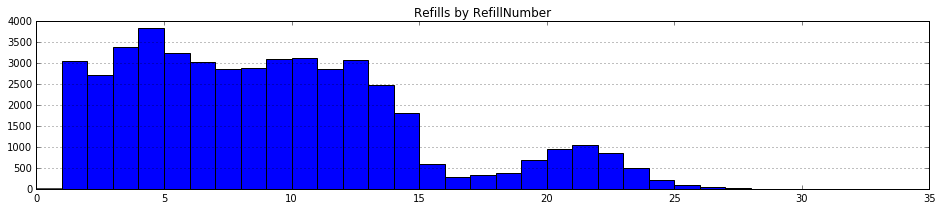

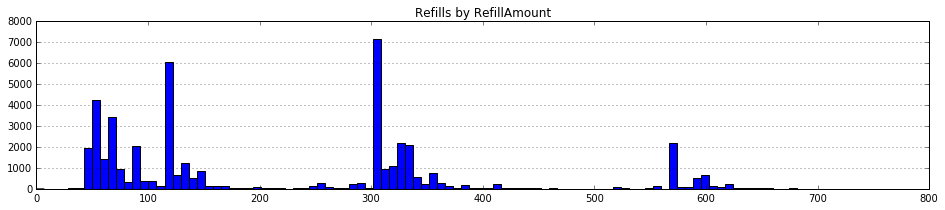

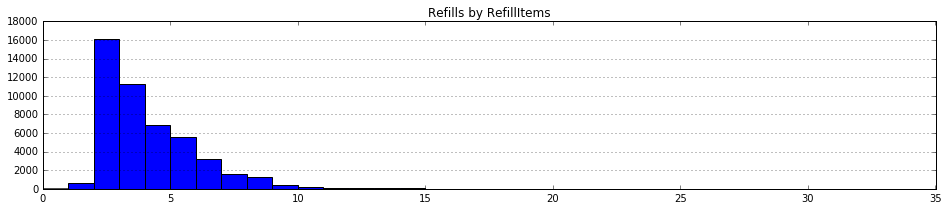

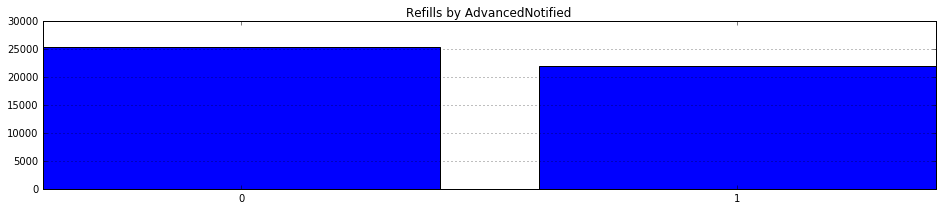

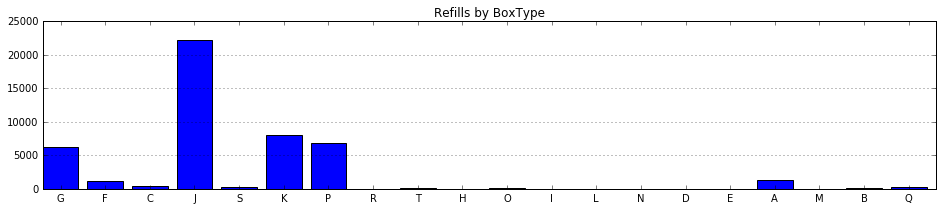

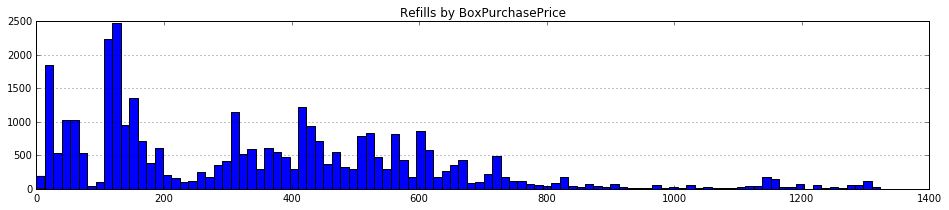

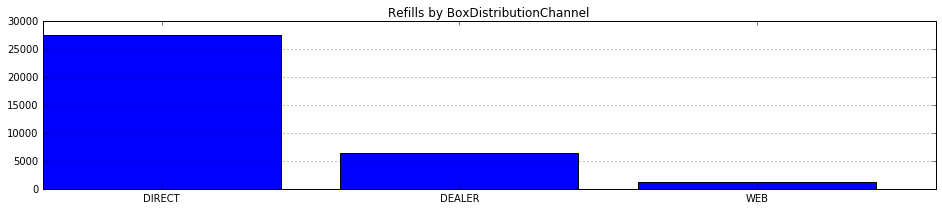

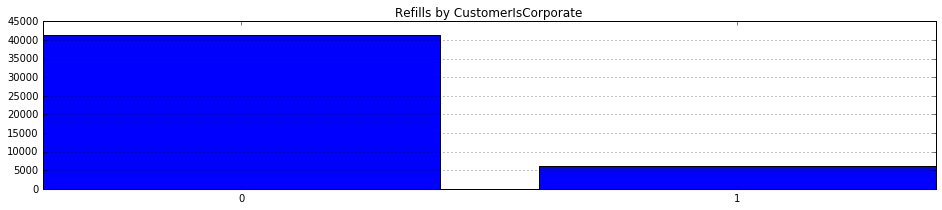

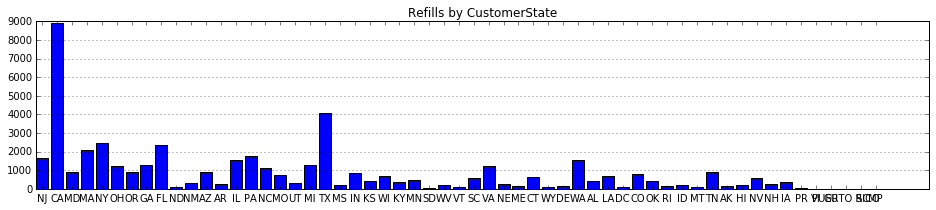

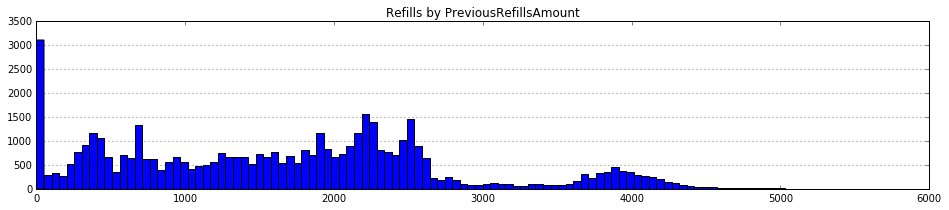

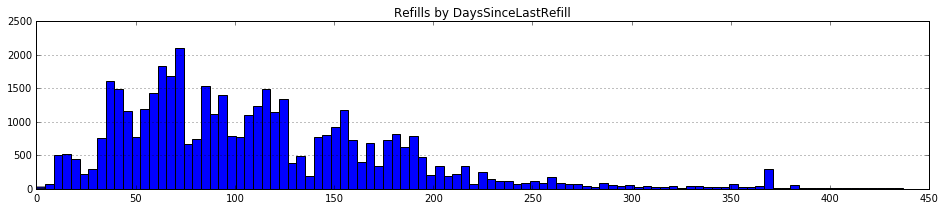

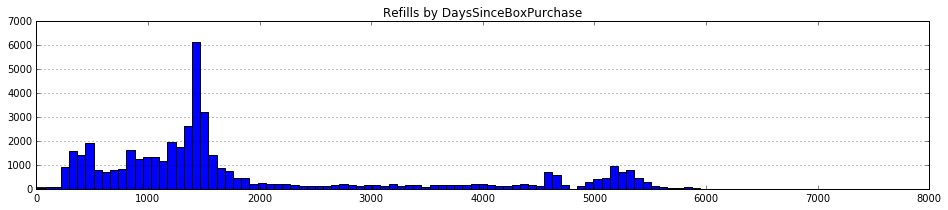

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
for col, col_data in X_raw.iteritems():
    plt.figure(figsize=(16,3))
    if col in category_columns:
        values = [x for x in col_data.unique() if x == x]
        index = np.arange(len(values))
        counts = list(col_data[col_data == value].count() for value in values)
        bar_width = 0.8
        
        plt.bar(index, counts, bar_width)
        plt.xticks(index + bar_width/2, values)
    else:
        bins = range(col_data.max() + 1) if len(col_data.unique()) < 100 else 100
        plot_data = [x for x in col_data.values if not np.isnan(x)]
        plt.hist(
            plot_data,
            bins=bins,
            range=[0, min(col_data.max(), col_data.mean() + 3*col_data.std())]
        )
    plt.title('Refills by ' + col)
    plt.grid(which='major', axis='y')
    plt.show()

`RefillNumber` is fairly evenly distributed at the lower end, with between 6% and 8% of the samples belonging to each `RefillNumber` value up to 12, after which it drops off sharply. `PreviousRefillsAmount` shares a similar distribution, dropping off after around \$2,500, which indicates a fairly consistent refill price. This is confirmed by examining the distribution of `RefillAmount`, which is heavily concentrated around \$100, \$300, and \$550. Also very consistent is the number of items contained in the refill, with nearly all of the samples having a `RefillItems` value between 2 and 6.

The distributions of `RefillNumber`, `PreviousRefillsAmount`, and `DaysSinceBoxPurchase` seem to indicate that there are two distinct box groups. Most of the samples belong to boxes sold in the past few years. However, there is also a smaller group of long-standing installs. The behavior of these two groups might differ significantly.

Other notes:
* `DaysSinceLastRefill` seems almost normally distributed around 60 days, though it is definitely skewed to the right.
* In contrast, `DaysSinceBoxPurchase` is heavily concentrated around 1,500 days.
* Around half of the refills were preceded by a notification.
* Around 60% of the refills belong to boxes that were sold directly to the customer.
* Almost half of the samples belong to `BoxType` J, and nearly all of the samples belong to `BoxType` G, J, K, or P.
* Over one-fifth of the samples belong to customers in California, with Texas coming in second place at around one-tenth. The other states are relatively evenly distributed.

## Algorithms and Techniques
Scalability is the name of the game, here. With nearly 48,000 samples on which to train, and more assuredly available in a production environment, the algorithm chosen must scale well in the number of samples. In addition, the algorithm must scale well in the number of features. We've identified 10 features to start with but that might, and probably will, grow quickly as the understanding of customer behavior improves. The number of features will likely never outgrow the number of samples, however.

The final model will be used to predict the result of upcoming refills on demand. A quick prediction time is therefore very important, and will it will only become more important as the customer base grows. Lazy learners would therefore not be suitable for this problem. On the other hand, training time is not a significant factor. As new data becomes available, the model can be retrained asynchronously and pushed to live when ready. Online learners would be ideal in this situation, as the true results of each refill are available after 45 days and the model could then be updated with the new information.

Based on the above, and by consulting the sklearn documentation on choosing an estimator, the following algorithms will be trained and tested:
* SGD Classifier
* Decision Trees (including random forest)

These two classifiers are discussed in more detail below:

### Decision Trees
A decision tree classifier immediately stood out to me as a worthy candidate for this situation. Decision trees are used in data mining as they are performant, scalable, and suited to both numerical and categorical data while requiring little data preparation. Perhaps most important when considering that this model must be applied in a non-technical environment, decision trees can be visualized and explained to the layman. A customer retention system would be much more effective it can be intuitively understood by the marketing and rention personnel responsible for its implementation.

### Stochastic Gradient Descent
Stochastic gradient descent (SGD) is not a model itself but rather a method of training models such as support vector machines (SVMs) and logistic regression models. Specifically, SGD is a method of finding the minima/maxima of a function by iteratively sweeping over randomly sampled subsets of the training set. It's often used for training neural nets, but those models will not be used in this project due to technical and experiential limitations. Instead, the loss functions made available by sklearn (linear SVMs, logistic regression, perceptron, and others) will be tested. The big benefit of SGD for this project is that it allows for online learning, meaning new results can more easily be incorporated into the model without having to retrain on the entire dataset.

## Benchmark
The business's assumption up to this point was that customers have not been properly educated of the refill process and were cancelling after receiving their first refill. Another assumption was that a few, high-priced items were responsible for a large proportion of the cancellations. These two assumptions together will define our benchmark, which will be as follows: if a refill is the box's first, assume deactivation. If the average item price in the refill is more than $200, assume deactivation. Otherwise, assume no change. For simplicity, the benchmark will be established as a binary classifier.

# Methodology
## Data Preprocessing
The following tasks need to be performed:
1. Impute missing values
  * To increase the predictor's accuracy, samples will be grouped by class before imputing.
  * First refills have a `NaN` value for `DaysSinceLastRefill`, which would be replaced with the mean during imputation. It would be more appropriate to transform the feature to its reciprocal and give first refills a value of zero.
* One-hot encode categorical features
  * One-hot encoding converts a single categorical feature into multiple binary features, where each binary feature represents a possible value of the original categorical feature. For example, `BoxDistributionChannel` has three values: Direct, Dealer, and Web. This feature will be converted to three features: `BoxDistributionChannel_Direct`, `BoxDistributionChannel_Dealer`, `BoxDistributionChannel_Web`. If the original value of `BoxDistributionChannel` was Direct, then that corresponding binary feature would have a value of 1 and the others 0.
  * This is necessary as not all algorithms work well (or at all) with categorical features. One-hot encoding allows these categorical features to be represented simply as vectors (e.g. [1,0,0] above), which is much easier to work with.

## Implementation
### Imputing and One-hot Encoding

In [5]:
# Impute missing values by class
def preprocess_refills(X_raw, y_all):
    X_imputed = pd.DataFrame()
    results = y_all.unique()
    for result in results:
        X_class = X_raw[y_all == result]
        X_class_imputed = pd.DataFrame(index = X_class.index)
        for col, col_data in X_class.iteritems():
            # Impute categorical with mode, numerical with mean
            fill_value = col_data.mode()[0] if col_data.dtype == object else col_data.mean()
            X_class_imputed = X_class_imputed.join(col_data.fillna(fill_value))
        X_imputed = X_imputed.append(X_class_imputed, verify_integrity = True)
    X_imputed.sort_index(inplace=True)

    X_processed = pd.DataFrame(index = X_imputed.index)
    for col, col_data in X_imputed.iteritems():
        # Transform DaysSinceLastRefill to reciprocal, fill NULL with 0
        if col == 'DaysSinceLastRefill':
            col_data = X_raw[col].rtruediv(1).replace(np.inf, 0).fillna(0)
            col_data.name = 'RefillFrequency'
        # Split categorical features into multiple binary columns
        elif col_data.dtype == object and set(col_data.unique()) != set([0,1]):
            col_data = pd.get_dummies(col_data, prefix=col)
        X_processed = X_processed.join(col_data)
    
    return X_processed

X_all = preprocess_refills(X_raw, y_all)
display(X_all.head())

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,BoxType_A,BoxType_B,BoxType_C,BoxType_D,BoxType_E,BoxType_F,...,CustomerState_VA,CustomerState_VI,CustomerState_VT,CustomerState_WA,CustomerState_WI,CustomerState_WV,CustomerState_WY,PreviousRefillsAmount,RefillFrequency,DaysSinceBoxPurchase
0,19,129.40,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3689.04,0.006410,3145
1,19,129.40,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3689.04,0.006410,3167
2,1,91.28,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.00,0.000000,3185
3,2,115.45,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,91.28,0.026316,3223
4,8,320.50,8,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1498.30,0.002695,5190


### Performance Metric Definition
As discussed above, we will be using a custom metric that takes into account both precision and recall in the following way:
* If the precision is less than 0.9, the score is zero
* Otherwise, the score is the recall score

In [6]:
from sklearn.metrics import recall_score, precision_score, make_scorer
labels = ['Deactivated', 'Downgraded']

def scoring_function(y_true, y_pred):
    precision = precision_score(y_true, y_pred, labels=labels, average='micro')
    if precision < 0.9:
        return 0
    return recall_score(y_true, y_pred, labels=labels, average='micro')

scorer = make_scorer(scoring_function)
recall_scorer = make_scorer(recall_score, labels=labels, average='micro')
precision_scorer = make_scorer(precision_score, labels=labels, average='micro')

### Benchmarking and Initial Algorithm Testing
Before training can begin, the data must be split into training and testing sets composing 80% and 20% of the total dataset, respectively. The testing set will be reserved for validating the final, tuned model. In this way, we can avoid overfitting and ensure that the final model generalizes well to unseen data.

During training, the performance of each algorithm will be tested using cross-validation. The process of cross-validation is as follows:
1. The training set is partitioned into a number of smaller subsets or "folds" (three, in this case)
2. One of the folds is reserved as the testing fold
3. The model is trained on the non-reserved folds
4. The model's performance is tested on the reserved testing fold
5. Steps 2-4 are repeated until each fold has been used as the testing fold exactly once
6. The performance of the model is taken as the average of its performance in each of the above iterations
    
Cross-validation maximizes the amount of data available for training while ensuring the model is still tested against unseen data, which is critical to any performance measurement.

In both the train/test split and cross-validation outlined above, the distribution of the classes will be preserved by ensuring that, after each split, the resulting subsamples have the same class distribution as the dataset as a whole. This is especially important, given the heavily unbalanced dataset.

As discussed above, we will be testing `SGDClassifier`, `DecisionTreeClassifier`, and `RandomForestClassifier`. in addition to the benchmark. All parameters for the classifiers will be left at default values, as a parameter grid search will be conducted later on to find the optimum values. This initial test will validate the data preprocessing performed above and allow for comparing the initial, untuned performance of the algorithms.

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

# Prepare candidate algorithms
random_state = 1993
results = []
classifiers = [
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    SGDClassifier(random_state=random_state)
]
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=random_state
)

# Establish benchmark
y_bench = []
for index, row in X_train.iterrows():
    if row['RefillNumber'] == 1:
        y_bench.append(1)
    elif row['RefillAmount']/row['RefillItems'] >= 200:
        y_bench.append(1)
    else:
        y_bench.append(0)
y_bench = pd.Series(y_bench)
y_true = 1 - pd.get_dummies(y_train)['No change']
results.append([
    'Benchmark',
    recall_score(y_true, y_bench),
    precision_score(y_true, y_bench)
])

# Test candidate algorithms
for clf in classifiers:
    classifier = clf.__class__.__name__
    recall = cross_val_score(clf, X_train, y_train, scoring=recall_scorer, n_jobs=-1)
    precision = cross_val_score(clf, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
    results.append([classifier, recall.mean(), precision.mean()])

results = pd.DataFrame(
    data = results,
    columns = [
        'classifier',
        'recall',
        'precision'
    ]
)

display(results)

,classifier,recall,precision
0,Benchmark,0.274942,0.086307
1,DecisionTreeClassifier,0.223924,0.187479
2,RandomForestClassifier,0.134582,0.469418
3,SGDClassifier,0.015099,0.037342


The benchmark model is clearly lacking. Though it catches more cancellations (27.5%) than any of the other algorithms, it also has the second to lowest precision of the lot. On the other hand, the random forest has the second to lowest recall but the highest precision. `SGDClassifier` has the lowest performance in both metrics. I'm interested to see how this changes after further tuning.

### Parameter Tuning
Each algorithms takes a number of parameters as inputs. These parameters can drastically affect the performance of the algorithm. In the case of SGD, different values of the `loss` parameter correspond to completely different models. Unfortunately, the highest-performing combination of parameters cannot be determined *a priori* but rather must simply be tested. This process is called parameter tuning.

One can imagine each possible combination of parameters as a cell in an n-dimensional grid, where n corresponds to the number of parameters being tuned. This grid is then exhaustively searched for the "best" parameter values, where the performance of each cell is tested using cross-validation (as outlined above). The highest-performing parameter values are then reported, along with their score.

For the decision tree and random forest classifiers, the following parameters are tuned:
* `criterion`: the metric of information gain used at each step in the decision tree
* `max_features`: the number of features considered at each step in the tree when evaluating which feature best partitions the data, according the metric defined by the `criterion` parameter
* `max_depth`: the maximum depth of the tuned tree. Decision trees have a tendency to overfit, so deeper is not always better.
* `min_samples_split`: the minimum number of samples needed in order to consider adding another split to the tree.

One addition parameter is tuned for `RandomForestClassifier`:
* `n_estimators`: the number of decision trees to train, the combination of which compose the *random forest*

In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
parameters = [
    {
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (2, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000)
    }
]
clf = GridSearchCV(DecisionTreeClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best DecisionTreeClassifier score: {}".format(clf.best_score_)
print clf.best_params_

Best DecisionTreeClassifier score: 0.113688103654
{'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 4}


In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = [
    {
        'n_estimators': (2, 5, 10, 15, 20, 25, 50, 75, 100),
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (2, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000)
    }
]
clf = GridSearchCV(RandomForestClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best RandomForestClassifier score: {}".format(clf.best_score_)
print clf.best_params_

Best RandomForestClassifier score: 0.155463101231
{'max_features': None, 'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}


The following parameters will be tuned for `SGDClassifier`, many of which are discussed in more detail above:
* `loss`: as mention above, this corresponds to the loss function or model being trained.
* `n_iter`: the number of passes, or iterations, over the training set
* `warm_start`: whether or not the result of a previous iteration should be used when initializing the next iteration
* `penalty`, `alpha`, and `l1_ratio` are variables in the loss function

In [10]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = [
    {
        'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
        'penalty': ('none', 'l2', 'l1', 'elasticnet'),
        'alpha': (0.0001, 0.001, 0.01),
        'l1_ratio': (0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0),
        'n_iter': (1, 5, 10, 50, 100),
        'warm_start': (True, False)
    }
]
clf = GridSearchCV(SGDClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best SGDClassifier score: {}".format(clf.best_score_)
print clf.best_params_

Best SGDClassifier score: 0.00115752926863
{'warm_start': False, 'n_iter': 100, 'loss': 'log', 'l1_ratio': 0.125, 'fit_intercept': True, 'penalty': 'elasticnet', 'alpha': 0.01}


# Results
## Model Evaluation and Validation
Based on the tuned performance of the models above, `RandomForestClassifier` seems to be a clear winner; in particular, a random forest of 50 decision trees, each of which has no maximum depth but stops splitting once the sample size is less than 10. To confirm these parameters' performance, the model will now be tested against the testing set, which contains as-yet unseen samples.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier   
clf = RandomForestClassifier(
    max_features = None,
    min_samples_split = 10,
    criterion = 'entropy',
    max_depth = None,
    n_estimators = 50,
    random_state=random_state
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
recall = recall_score(y_test, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')
precision = precision_score(y_test, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')
print "Test Recall: {}".format(recall)
print "Test Precision: {}".format(precision)

Test Recall: 0.162790697674
Test Precision: 0.945945945946


This model generalizes well to unseen data. Its performance on the testing set (score of 0.155) is very similar to its performance on the training set (score of 0.163). Even better, its performance is reasonably strong. Its precision is above the required threshold of 0.9, and its recall of 0.163 is more than enough to consider using the model in a test intervention system. Moreover, it is much more accurate than the benchmark. The simple model formed by the assumptions the business had been making only had a recall of 0.274942 and precision of 0.086307. In other words, it predicted more of the cancellations, but it also predicted cancellation far more often than was true.

The benchmark model would be useless in an intervention system as the value recovered from saving potential quits would quickly be burnt pursuing the wrong targets. In contrast, the random forest classifier trained above rarely predicts a cancellation that is unwarranted. However, its clear that some aspect of the problem is still not being captured by the data. I believe that identifying additional relevant features - for example, by conducting exit interviews with customers who cancelled unpredictedly - will improve the recall. In the meantime, I believe that this model can still save a significant number of customers.

# Conclusion
## Free-Form Visualization

A predictor is useful, but far more useful is intuitive understanding of the problem at hand. It's lucky, then, that the two highest-performing models (the decision tree and, by extension, the random forest) can be represented visually. The behavior of the important features will be explored below.

,importance
DaysSinceBoxPurchase,0.229165
BoxPurchasePrice,0.201741
PreviousRefillsAmount,0.100738
RefillFrequency,0.098787
RefillAmount,0.059242
RefillNumber,0.026945
CustomerState_CA,0.022067
RefillItems,0.020982
CustomerIsCorporate,0.014289
CustomerState_NY,0.011180


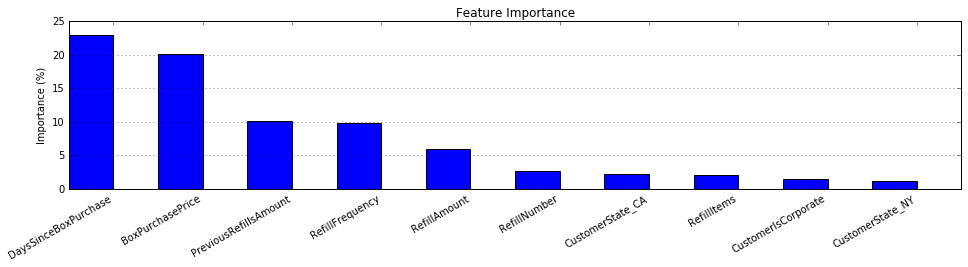

In [12]:
relevance = pd.DataFrame([clf.feature_importances_], index=['importance'], columns = X_train.columns)
relevance = relevance[relevance > 0.01].dropna(axis=1).transpose().sort_values('importance', ascending = False)
display(relevance)

relevance_data = relevance['importance'] * 100
N = len(relevance_data)
index = np.arange(N)
width = 0.5

plt.figure(figsize=(16,3))
plt.bar(index, relevance_data, width)
plt.xticks(index + width, relevance.index, rotation=30, ha='right')
plt.ylabel('Importance (%)')
plt.title('Feature Importance')
plt.grid(which='major', axis='y')
plt.show()

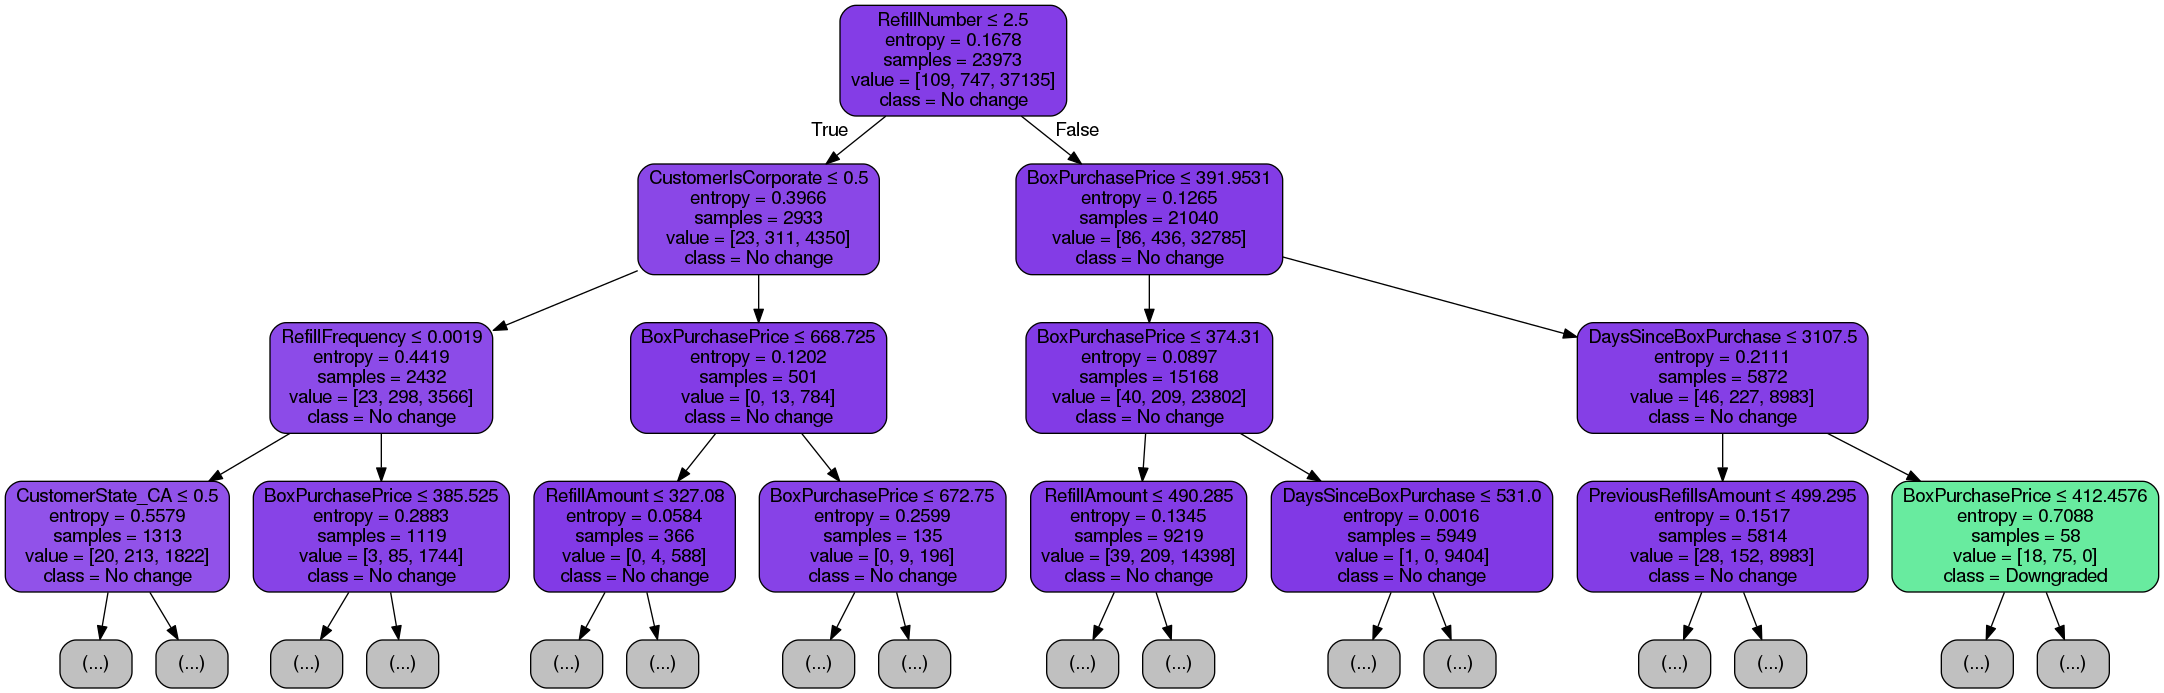

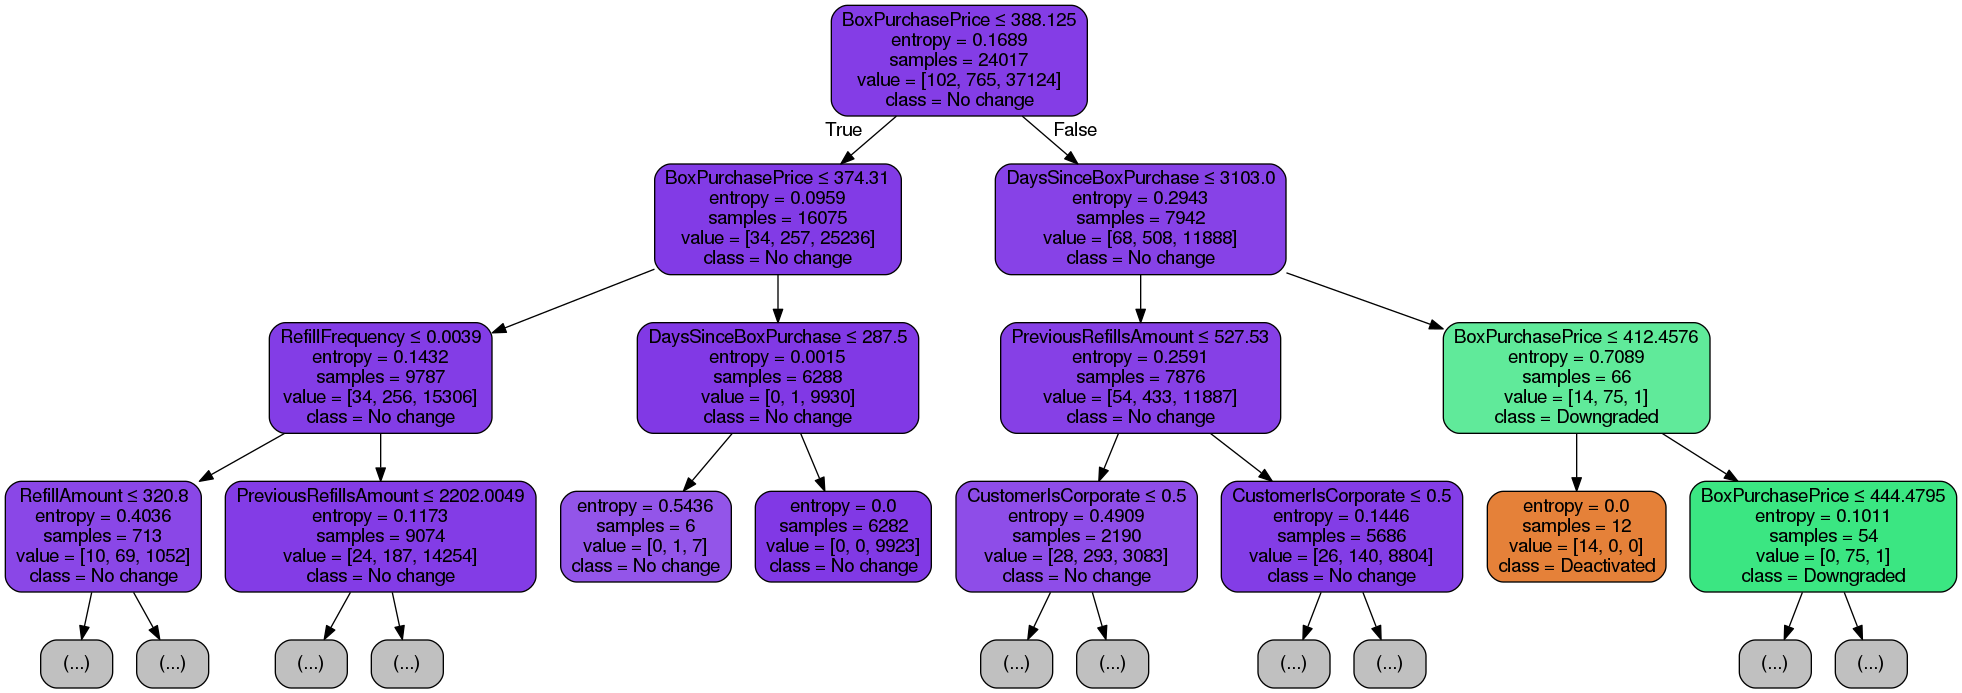

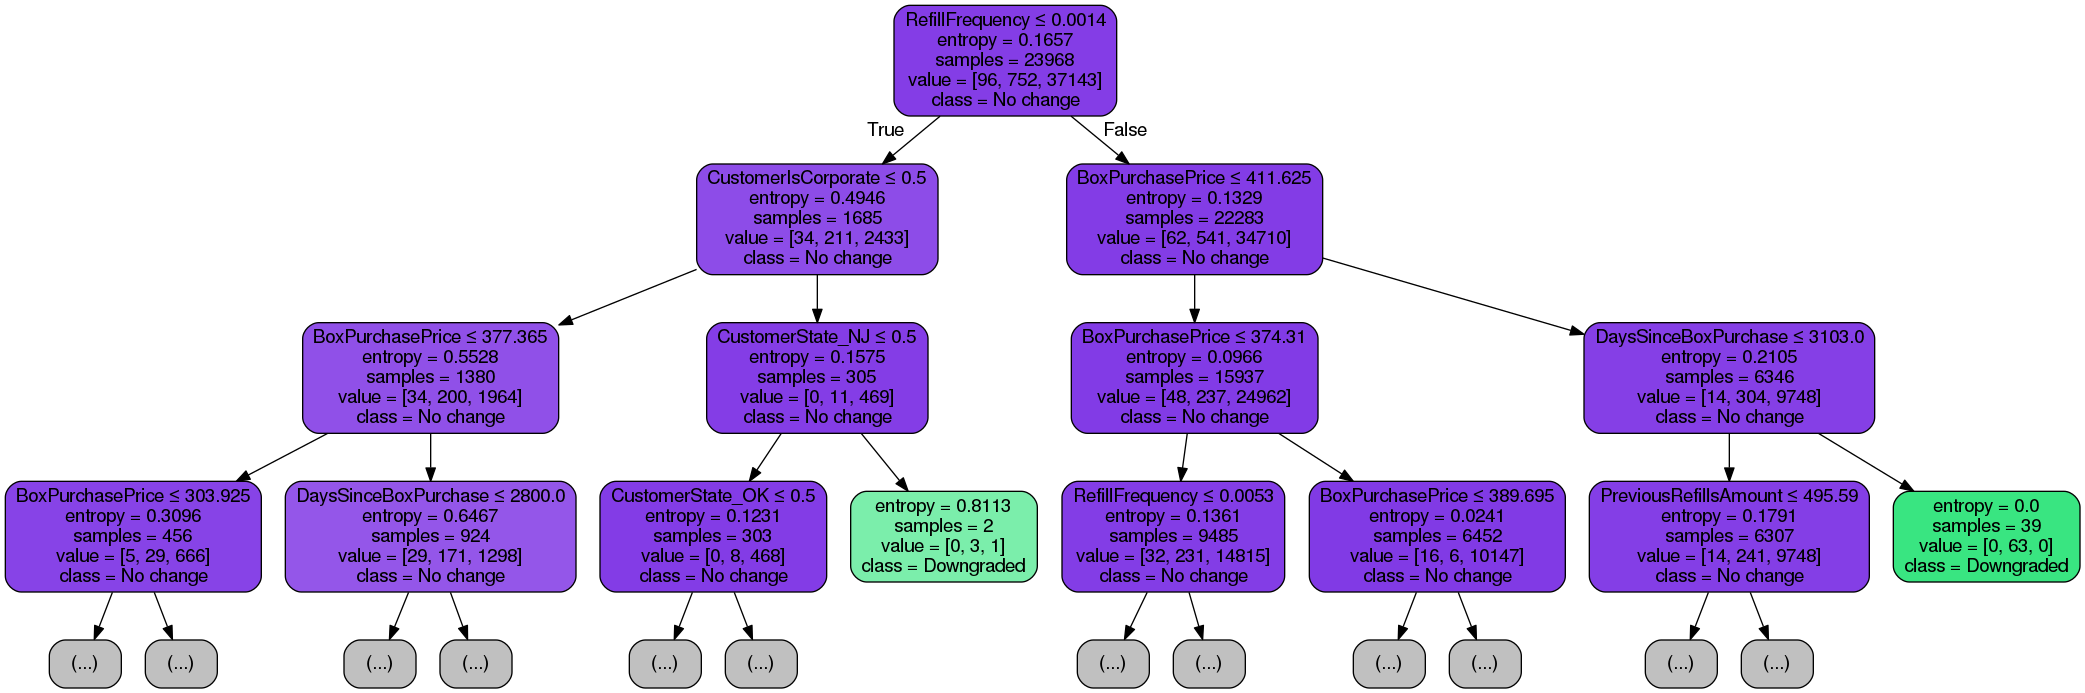

In [13]:
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data

for dt in clf.estimators_[:3]:
    dot_data = StringIO()  
    export_graphviz(
        dt,
        out_file=dot_data,
        feature_names=X_all.columns,
        class_names=clf.classes_,
        max_depth=3,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

It seems that the predictor has uncovered a pattern of high cancellation among low-priced boxes that have been active for a long time. After some consideration, this makes sense. Even highly-satisfied customers will eventually cancel, for example due to a change in circumstance such as retiring. Such customers might neglect to cancel their subscription. Then, after receiving a refill they might not have been expecting, they would have to go through the process of returning the items and cancelling the subscription, all of which involves lost time and money. This predictor would be able to identify such customers and prevent that waste with some effort beforehand.

## Reflection
To recap, the process undertaken in this project:
1. Data preparation: identifying potentially relevant features of each refill, locating and/or calculating these features in the data, and determining the label for each sample
* Data visualization: exploring the distribution of the data, both to form a stronger understanding of the relationship between the features and to identify any preprocessing necessary before training
* Algorithm selection: taking into account the details of the problem at hand to choose a handful of candidate algorithms for training
* Benchmarking: Outlining and testing a benchmark against which the candidate algorithms can be measured
* Feature preprocessing: carrying out the preprocessing as identified in the data visualization and exploration stage, including imputing missing values and one-hot encoding categorical features
* Algorithm parameter tuning: train/test splitting the data, then performance parameter grid searches with cross-validation to identify the highest-performing model of the candidates
* Validation testing: testing the performance of the chosen model against a validation data set

Far and away, the main challenge in this project was in preparing the data. Many new views were prepared involving several tables. For example, the necessary table relationships to uncover purchase information for boxes had to be discovered, and these were still not enough to overcome data integrity issues for older boxes. These data integrity issues continued to complicate the project beyond the data preparation phase. Missing values for certain features needed to be imputed in the preprocessing phase. On the other hand, there is an abundance of available data. Modeling such an unbalanced problem would be highly innacurate were there not tens of thousands of available samples. Moreover, I have already begun the process of improving data storage protocols, including ensuring that certain historical data is stored to make reporting easier (or, in some cases, simply possible) in the future. This will enable further iterative improvement of the predictor.

Two issues mentioned above impacted the project in both positive and negative ways: the large amount of data and the unbalanced classes. A large dataset is a luxury, but it also led to comparatively long training times. Performing a parameter grid search took upwards of a few hours for the more complicated algorithms, even on a powerful dedicated machine. The unbalanced classes made choosing a performance metric a novel and engaging challenge. However, I suspect they also raise the standard on the input data for producing a high-quality model.

At this point, though, I am quite pleased with the result of this project. For several reasons, not least among them being my own novicehood, I was not expecting the final model to have as high a precision as it does. To be sure, I would prefer that the precision had also exceeded my expectation. All that said, I feel quite comfortable testing this model in a production-like environment.

## Improvement
As I've mentioned above, I believe that adding additional relevant features will improve the recall. In particular, the business believes that certain key, high-priced items are possibly triggering cancellations. I've considered adding a boolean "is_included" feature for each of those items. Also, the data has a focus on boxes rather than customers. For example, if a customer were to cancel a box and purchase a new one, this is not explicitly reflected in the data at the moment. Further, features like customer lifetime and balance due at the time of refill might expose critical patterns in behavior.

Exploring the customer angle further, I've also had the idea to perform a customer segmentation analysis. Such an analysis could provide valuable insight into customer behavior in addition to providing a few relevant features for training the predictor. The first of these would obviously be the segment number of the customer to which the box belongs. Clustering would also allow me to establish an average customer lifetime value (CLV) for each segment. A cost function for the predictor could then be defined using this CLV in the following way: if the predictor fails to catch a cancellation, it will incur a penalty of the deficit between that customer's current lifetime value and the average CLV for that customer's segment. In this way, the process of fitting the model to the data will be directly optimizing the potential value that could be recovered by using the predictor.

Finally, I will admit to being disappointed that the `SGDClassifier` algorithm did not perform very well. An online learner would be a big bonus for iteratively improving the predictor. One such learner I left out of this project, mostly due to lacking the requisite experience, is a neural net. Though it carries with it the disadvantage of being black boxes, it is an online learner with a strong reputation in the industry today.